In [ ]:
# Import necessary libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from scipy.stats import pearsonr

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from Excel files
energy_data = pd.read_excel("/content/drive/My Drive/energy.xlsx", sheet_name=["Motor fuel inflation", "Gas inflation"], skiprows=5)
food_data = pd.read_excel("/content/drive/My Drive/food.xlsx", sheet_name=["Food inflation", "Restaurant and cafe inflation"], skiprows=5)


In [ ]:
energy_data['Motor fuel inflation']

Date   Motor fuels
0   2012-10-01          2.4
1   2012-11-01          1.0
2   2012-12-01         -0.2
3   2013-01-01         -0.8
4   2013-02-01          0.8
..         ...          ...
131 2023-09-01         -9.7
132 2023-10-01         -7.6
133 2023-11-01        -10.6
134 2023-12-01        -10.8
135 2024-01-01         -9.2

[136 rows x 2 columns]

In [ ]:
energy_data['Gas inflation']

Date   Gas 
0   2012-10-01  -1.0
1   2012-11-01  -0.1
2   2012-12-01   5.2
3   2013-01-01   5.2
4   2013-02-01   7.2
..         ...   ...
131 2023-09-01   1.7
132 2023-10-01 -31.0
133 2023-11-01 -31.0
134 2023-12-01 -31.0
135 2024-01-01 -26.5

[136 rows x 2 columns]

In [ ]:
food_data['Food inflation']

Date   Food and non-alcoholic beverages
0   2012-10-01                               3.4
1   2012-11-01                               3.9
2   2012-12-01                               3.8
3   2013-01-01                               4.2
4   2013-02-01                               3.7
..         ...                               ...
131 2023-09-01                              12.2
132 2023-10-01                              10.1
133 2023-11-01                               9.2
134 2023-12-01                               8.0
135 2024-01-01                               7.0

[136 rows x 2 columns]

In [ ]:
food_data["Restaurant and cafe inflation"]

Date   Restaurants and caf√©s
0   2012-10-01                    2.9
1   2012-11-01                    3.0
2   2012-12-01                    3.0
3   2013-01-01                    2.9
4   2013-02-01                    2.9
..         ...                    ...
131 2023-09-01                    9.1
132 2023-10-01                    8.8
133 2023-11-01                    8.2
134 2023-12-01                    7.7
135 2024-01-01                    8.2

[136 rows x 2 columns]

In [ ]:
Motor_fuel_inflation = energy_data['Motor fuel inflation']
gas_inflation = energy_data['Gas inflation']
food_inflation = food_data['Food inflation']
restaurant_cafe_inflation = food_data['Restaurant and cafe inflation']

# Preprocess data

In [ ]:
# Preprocess each dataframe to ensure date is set as index and in datetime format
def preprocess_sheet(df, column_name):
    # Strip whitespace from column names to avoid issues with extra spaces
    df.columns = df.columns.str.strip()

    # Check if 'Date' column exists and convert it to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.dropna(subset=['Date'], inplace=True)
        df.set_index('Date', inplace=True)

        # Ensure only the relevant inflation column is kept
        if column_name not in df.columns:
            raise KeyError(f"'{column_name}' column not found in the sheet.")
        df = df[[column_name]]
    else:
        raise KeyError(f"'Date' column not found in the sheet for {column_name}.")

    return df

# Apply preprocessing to each dataset
Motor_fuel_inflation = preprocess_sheet(Motor_fuel_inflation, 'Motor fuels')
gas_inflation = preprocess_sheet(gas_inflation, 'Gas')
food_inflation = preprocess_sheet(food_inflation, 'Food and non-alcoholic beverages')
restaurant_cafe_inflation = preprocess_sheet(restaurant_cafe_inflation, 'Restaurants and caf√©s')

# Verify preprocessing results by displaying the first few rows of each dataframe
print("Motor Fuel Inflation Data:\n", Motor_fuel_inflation.head())
print("\nGas Inflation Data:\n", gas_inflation.head())
print("\nFood Inflation Data:\n", food_inflation.head())
print("\nRestaurant and Cafe Inflation Data:\n", restaurant_cafe_inflation.head())

Motor Fuel Inflation Data:
             Motor fuels
Date                   
2012-10-01          2.4
2012-11-01          1.0
2012-12-01         -0.2
2013-01-01         -0.8
2013-02-01          0.8

Gas Inflation Data:
             Gas
Date           
2012-10-01 -1.0
2012-11-01 -0.1
2012-12-01  5.2
2013-01-01  5.2
2013-02-01  7.2

Food Inflation Data:
             Food and non-alcoholic beverages
Date                                        
2012-10-01                               3.4
2012-11-01                               3.9
2012-12-01                               3.8
2013-01-01                               4.2
2013-02-01                               3.7

Restaurant and Cafe Inflation Data:
             Restaurants and caf√©s
Date                             
2012-10-01                    2.9
2012-11-01                    3.0
2012-12-01                    3.0
2013-01-01                    2.9
2013-02-01                    2.9


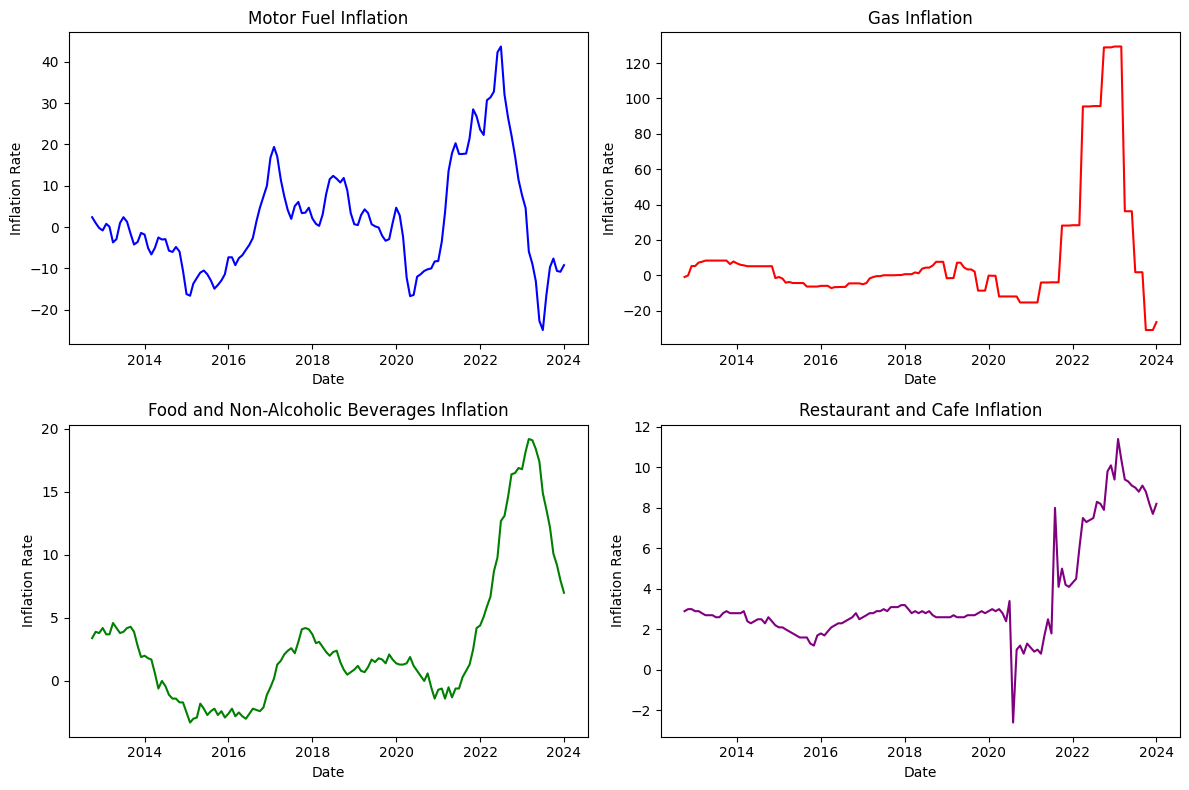

In [ ]:
# Import libraries
import matplotlib.pyplot as plt

# Plot each dataset to visualize inflation trends
plt.figure(figsize=(12, 8))

# Motor Fuel Inflation
plt.subplot(2, 2, 1)
plt.plot(Motor_fuel_inflation.index, Motor_fuel_inflation['Motor fuels'], color='blue')
plt.title('Motor Fuel Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

# Gas Inflation
plt.subplot(2, 2, 2)
plt.plot(gas_inflation.index, gas_inflation['Gas'], color='red')
plt.title('Gas Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

# Food Inflation
plt.subplot(2, 2, 3)
plt.plot(food_inflation.index, food_inflation['Food and non-alcoholic beverages'], color='green')
plt.title('Food and Non-Alcoholic Beverages Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

# Restaurant and Cafe Inflation
plt.subplot(2, 2, 4)
plt.plot(restaurant_cafe_inflation.index, restaurant_cafe_inflation['Restaurants and caf√©s'], color='purple')
plt.title('Restaurant and Cafe Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

plt.tight_layout()
plt.show()


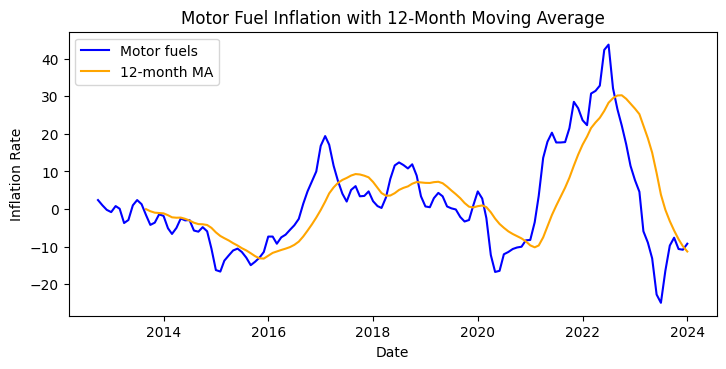

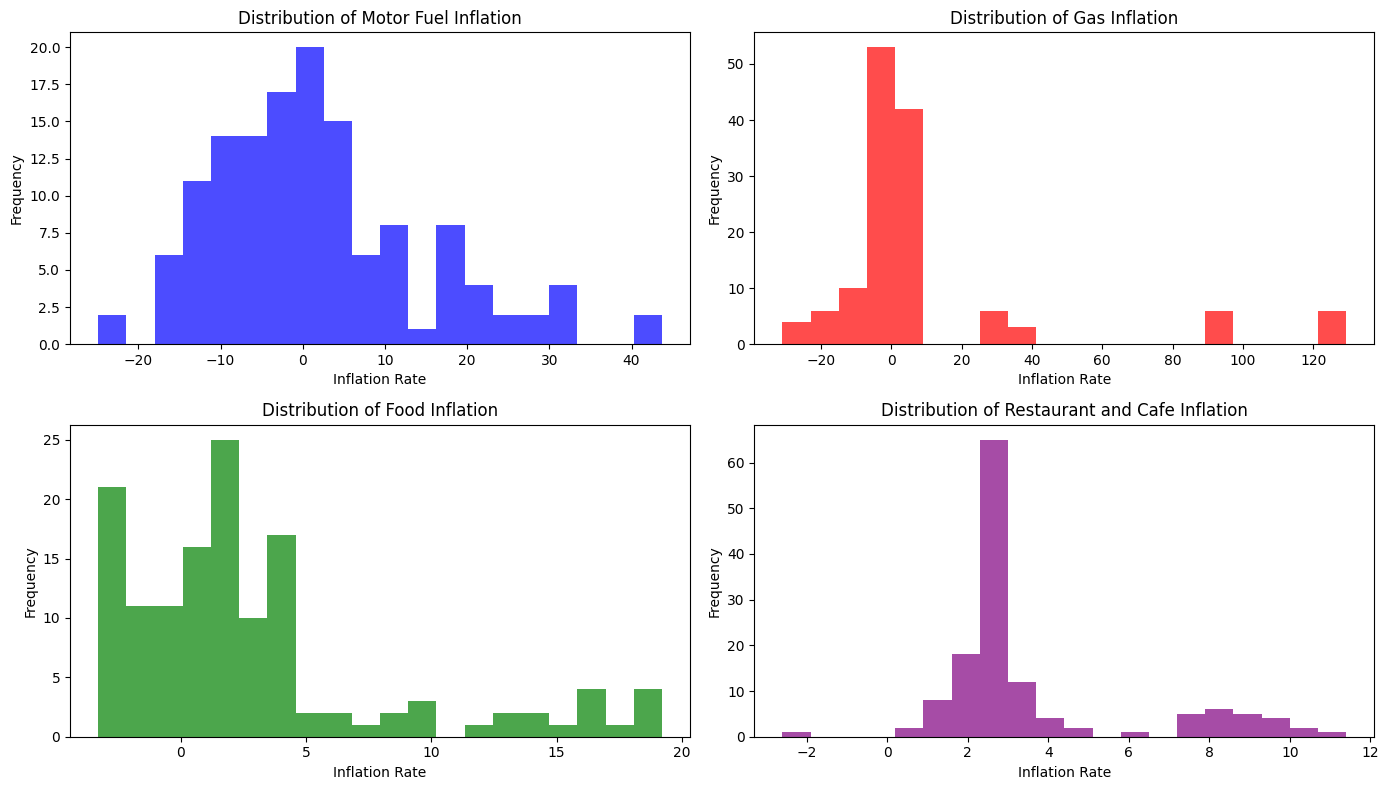

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot each dataset to visualize inflation trends
plt.figure(figsize=(14, 10))


# Moving Average (Example: 12-month moving average for Motor Fuel Inflation)
Motor_fuel_inflation['12-month MA'] = Motor_fuel_inflation['Motor fuels'].rolling(window=12).mean()
plt.subplot(3, 2, 5)
plt.plot(Motor_fuel_inflation.index, Motor_fuel_inflation['Motor fuels'], label='Motor fuels', color='blue')
plt.plot(Motor_fuel_inflation.index, Motor_fuel_inflation['12-month MA'], label='12-month MA', color='orange')
plt.title('Motor Fuel Inflation with 12-Month Moving Average')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Histograms to show distribution of inflation rates in each category
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.hist(Motor_fuel_inflation['Motor fuels'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Motor Fuel Inflation')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(gas_inflation['Gas'], bins=20, color='red', alpha=0.7)
plt.title('Distribution of Gas Inflation')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(food_inflation['Food and non-alcoholic beverages'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of Food Inflation')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(restaurant_cafe_inflation['Restaurants and caf√©s'], bins=20, color='purple', alpha=0.7)
plt.title('Distribution of Restaurant and Cafe Inflation')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



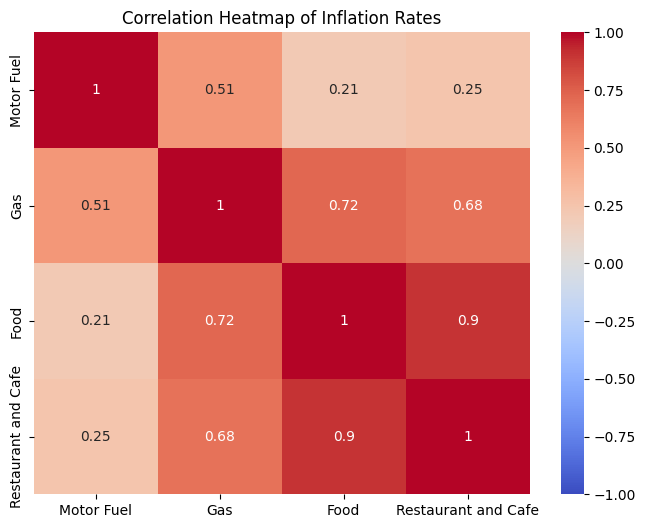

In [ ]:
# Correlation heatmap to show relationships between inflation rates
# Merge data for correlation analysis
merged_data = pd.concat([
    Motor_fuel_inflation['Motor fuels'],
    gas_inflation['Gas'],
    food_inflation['Food and non-alcoholic beverages'],
    restaurant_cafe_inflation['Restaurants and caf√©s']
], axis=1)

merged_data.columns = ['Motor Fuel', 'Gas', 'Food', 'Restaurant and Cafe']

plt.figure(figsize=(8, 6))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Inflation Rates')
plt.show()

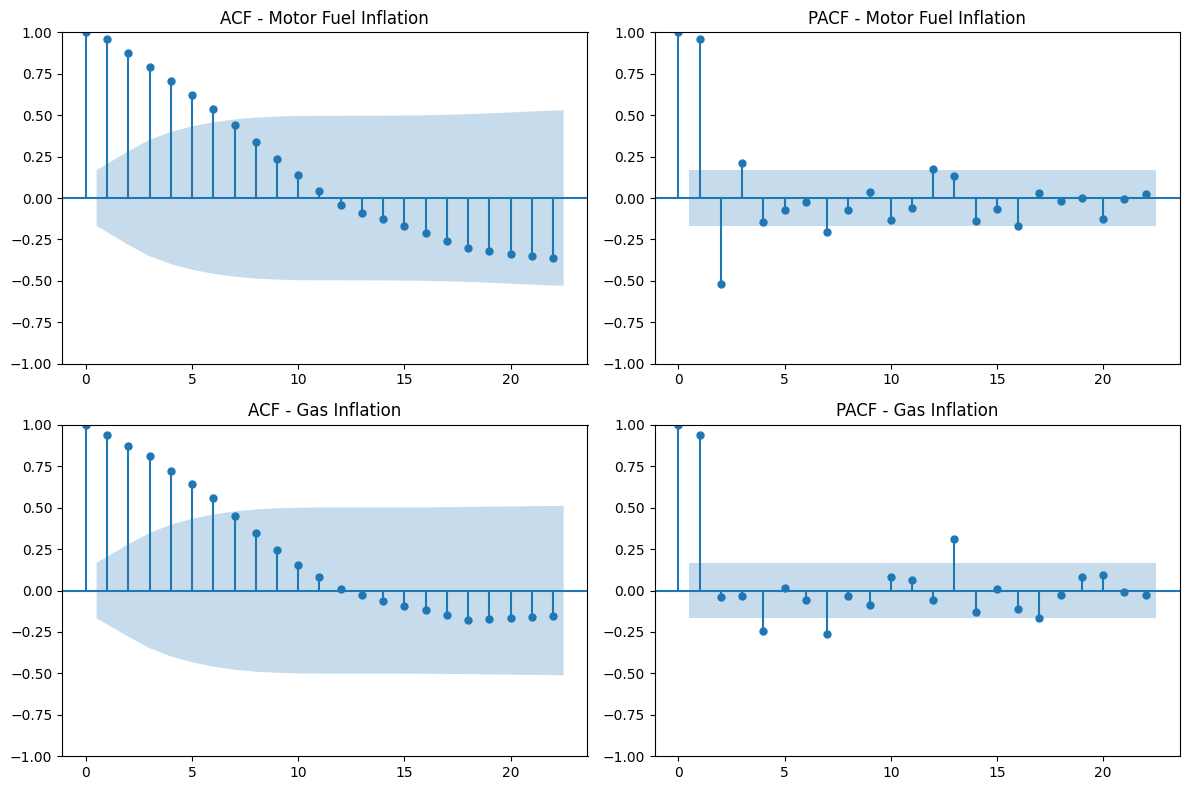

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(Motor_fuel_inflation['Motor fuels'].dropna(), ax=axes[0, 0], title="ACF - Motor Fuel Inflation")
plot_pacf(Motor_fuel_inflation['Motor fuels'].dropna(), ax=axes[0, 1], title="PACF - Motor Fuel Inflation")

plot_acf(gas_inflation['Gas'].dropna(), ax=axes[1, 0], title="ACF - Gas Inflation")
plot_pacf(gas_inflation['Gas'].dropna(), ax=axes[1, 1], title="PACF - Gas Inflation")

plt.tight_layout()
plt.show()


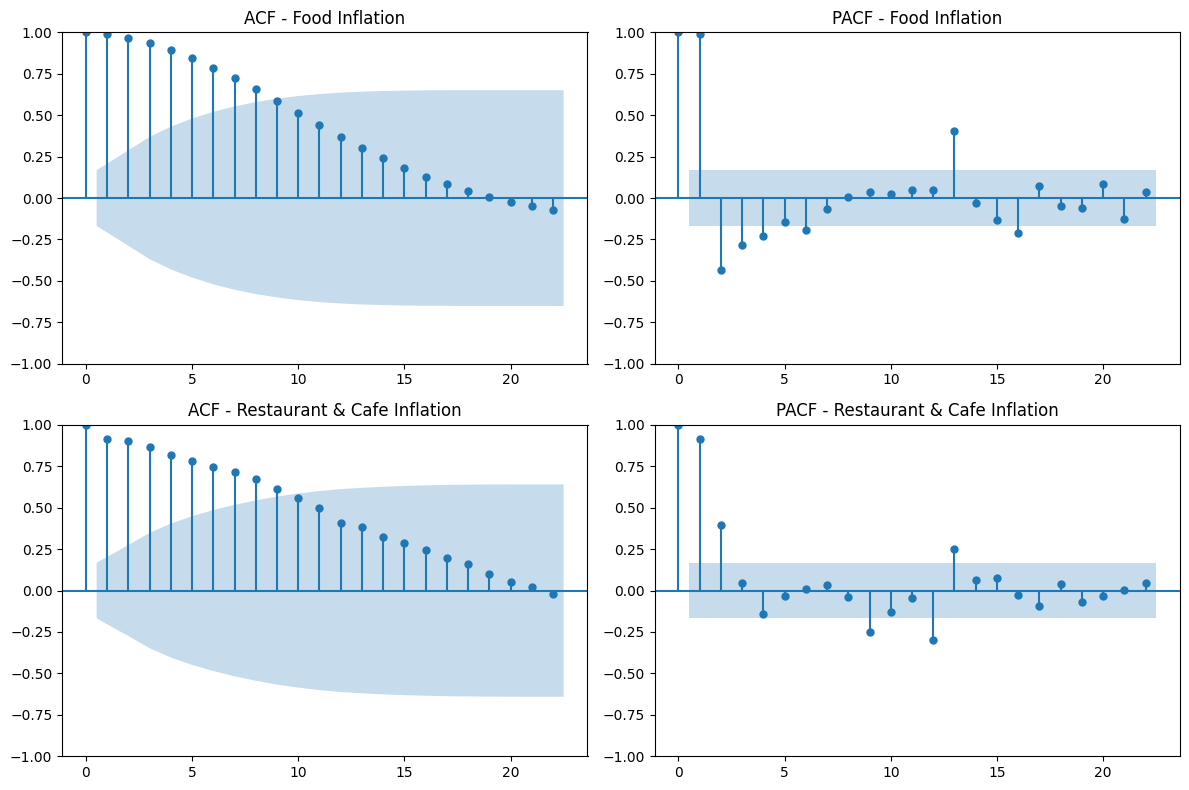

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))


# Food Inflation
plot_acf(food_inflation['Food and non-alcoholic beverages'].dropna(), ax=axes[0, 0], title="ACF - Food Inflation")
plot_pacf(food_inflation['Food and non-alcoholic beverages'].dropna(), ax=axes[0, 1], title="PACF - Food Inflation")

# Restaurant & Cafe Inflation
plot_acf(restaurant_cafe_inflation['Restaurants and caf√©s'].dropna(), ax=axes[1, 0], title="ACF - Restaurant & Cafe Inflation")
plot_pacf(restaurant_cafe_inflation['Restaurants and caf√©s'].dropna(), ax=axes[1, 1], title="PACF - Restaurant & Cafe Inflation")

plt.tight_layout()
plt.show()


# SARIMA

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

ADF Test for Motor Fuel Inflation:
ADF Statistic: -2.721598039975896
p-value: 0.07037485152910078
‚ùå Data is non-stationary (Consider differencing)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=648.703, Time=6.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1087.136, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=724.337, Time=0.81 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=917.757, Time=1.71 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1087.180, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=644.484, Time=0.93 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=686.041, Time=0.28 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=660.677, Time=0.85 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=646.553, Time=4.45 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=642.818, Time=1.76 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=686.768, Time=0.28 sec
 ARIMA(1,0,2)(1,0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ADF Test for Gas Inflation:
ADF Statistic: -0.49729539083222996
p-value: 0.8925432032067124
‚ùå Data is non-stationary (Consider differencing)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1006.865, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1050.428, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1021.730, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1004.400, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1048.463, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1052.428, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1006.377, Time=0.34 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1006.361, Time=0.64 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1021.730, Time=0.22 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1007.098, Time=0.88 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1002.400, Time=0.12 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1004.378, Time=0.25 sec
 ARIMA(0,

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=313.651, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=255.793, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=311.816, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=283.050, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=248.838, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=283.779, Time=0.32 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=229.034, Time=0.62 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=239.694, Time=0.24 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=216.365, Time=0.92 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ADF Test for Restaurant and Cafe Inflation:
ADF Statistic: -1.7888274627579954
p-value: 0.3860224860678631
‚ùå Data is non-stationary (Consider differencing)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=377.780, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=322.324, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=376.003, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=344.450, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=312.282, Time=0.39 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=340.669, Time=1.68 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=312.523, Time=1.05 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=313.218, Time=0.57 sec
 ARIMA(0,1,1)(2,0,0)[1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


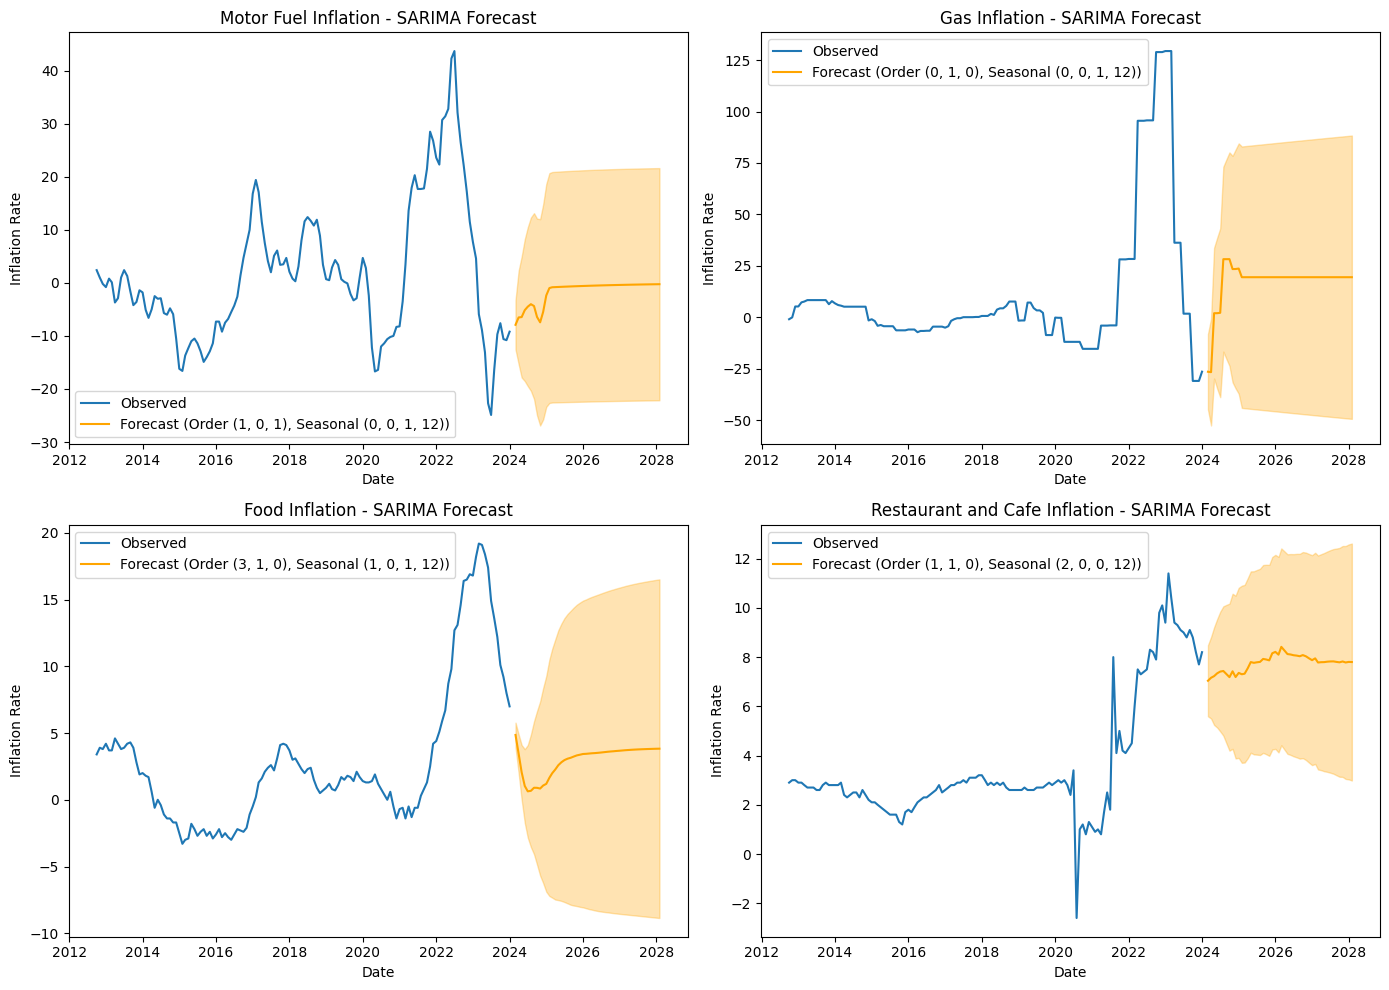

Best SARIMA Order for Motor Fuel Inflation: (1, 0, 1)
Best SARIMA Seasonal Order for Motor Fuel Inflation: (0, 0, 1, 12)

Best SARIMA Order for Gas Inflation: (0, 1, 0)
Best SARIMA Seasonal Order for Gas Inflation: (0, 0, 1, 12)

Best SARIMA Order for Food Inflation: (3, 1, 0)
Best SARIMA Seasonal Order for Food Inflation: (1, 0, 1, 12)

Best SARIMA Order for Restaurant and Cafe Inflation: (1, 1, 0)
Best SARIMA Seasonal Order for Restaurant and Cafe Inflation: (2, 0, 0, 12)



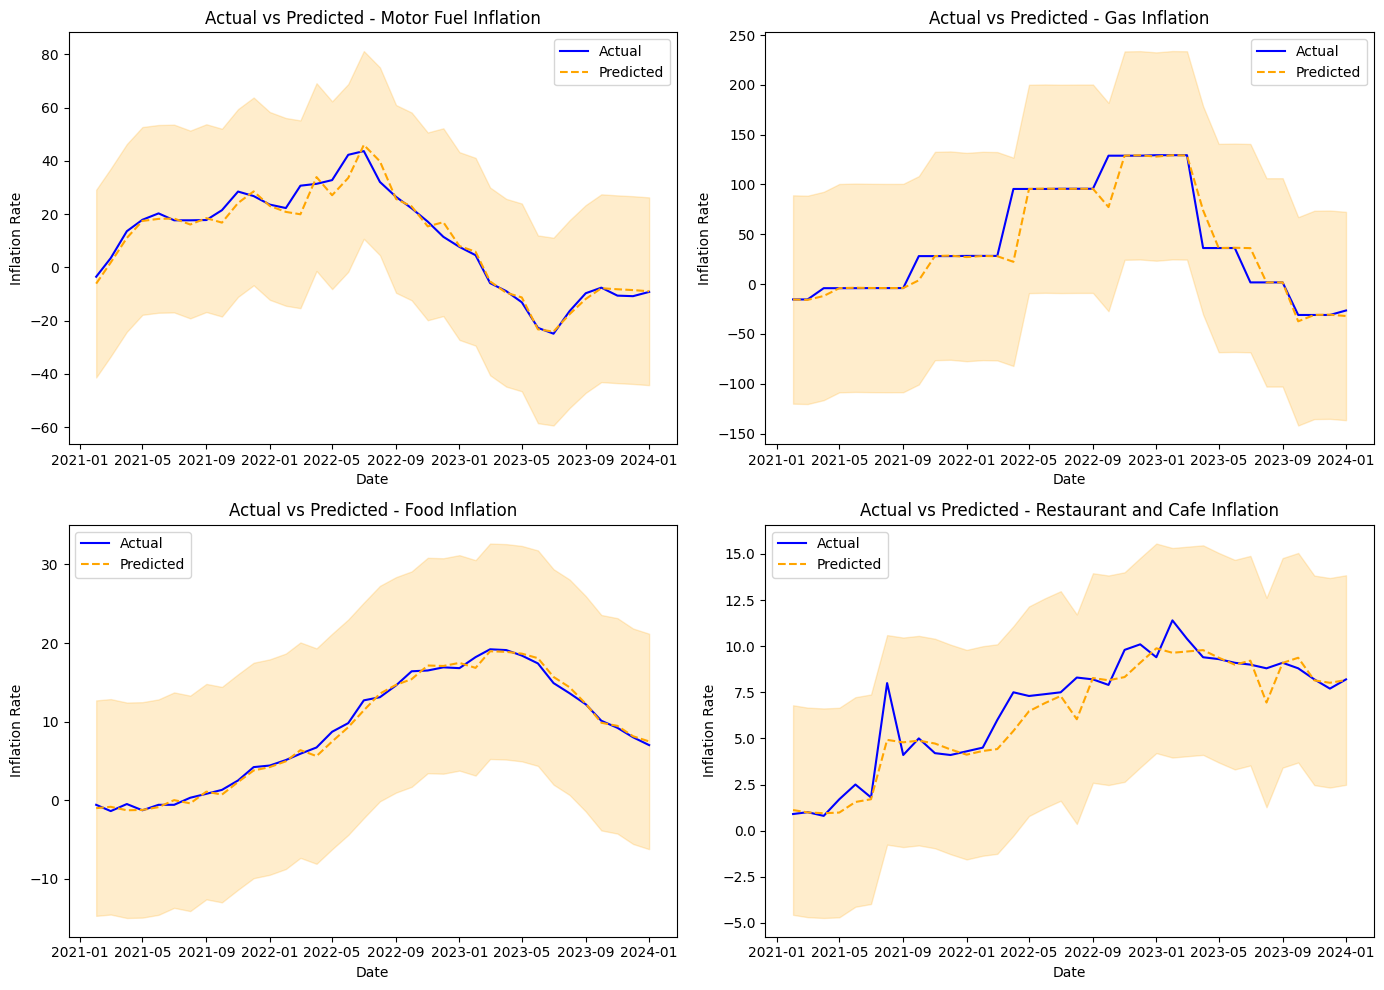

SARIMA Model Evaluation Metrics:


Dataset       MAE         MSE       RMSE
0           Motor Fuel Inflation  2.383615   11.739571   3.426306
1                  Gas Inflation  6.871588  315.222417  17.754504
2                 Food Inflation  0.509891    0.383286   0.619101
3  Restaurant and Cafe Inflation  0.666554    0.998896   0.999448

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to check stationarity using Augmented Dickey-Fuller (ADF) Test
def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f"ADF Test for {title}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("‚úÖ Data is stationary\n")
    else:
        print("‚ùå Data is non-stationary (Consider differencing)\n")


def sarima_forecast_auto(series, title, steps=48):  # üîπ Updated steps to 48 months (4 years)
    # Check stationarity before modeling
    check_stationarity(series, title)

    # Auto-select the best SARIMA order
    auto_model = auto_arima(series, seasonal=True, m=12, stepwise=True, trace=True)
    best_order = auto_model.order
    best_seasonal_order = auto_model.seasonal_order

    # Fit SARIMA model
    model = SARIMAX(series, order=best_order, seasonal_order=best_seasonal_order)
    sarima_model = model.fit(disp=False)

    # Forecast for full 4 years
    forecast = sarima_model.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()

    return forecast, forecast_ci, best_order, best_seasonal_order, sarima_model

# üîπ Update the steps for a 4-year forecast
motor_fuel_forecast, motor_fuel_ci, motor_fuel_order, motor_fuel_seasonal_order, motor_fuel_model = sarima_forecast_auto(
    Motor_fuel_inflation['Motor fuels'], 'Motor Fuel Inflation', steps=48)

gas_forecast, gas_ci, gas_order, gas_seasonal_order, gas_model = sarima_forecast_auto(
    gas_inflation['Gas'], 'Gas Inflation', steps=48)

food_forecast, food_ci, food_order, food_seasonal_order, food_model = sarima_forecast_auto(
    food_inflation['Food and non-alcoholic beverages'], 'Food Inflation', steps=48)

restaurant_cafe_forecast, restaurant_cafe_ci, restaurant_cafe_order, restaurant_cafe_seasonal_order, restaurant_cafe_model = sarima_forecast_auto(
    restaurant_cafe_inflation['Restaurants and caf√©s'], 'Restaurant and Cafe Inflation', steps=48)


# Dictionary to hold datasets and their SARIMA results
datasets = {
    'Motor Fuel Inflation': (Motor_fuel_inflation['Motor fuels'], motor_fuel_forecast, motor_fuel_ci, motor_fuel_order, motor_fuel_seasonal_order, motor_fuel_model),
    'Gas Inflation': (gas_inflation['Gas'], gas_forecast, gas_ci, gas_order, gas_seasonal_order, gas_model),
    'Food Inflation': (food_inflation['Food and non-alcoholic beverages'], food_forecast, food_ci, food_order, food_seasonal_order, food_model),
    'Restaurant and Cafe Inflation': (restaurant_cafe_inflation['Restaurants and caf√©s'], restaurant_cafe_forecast, restaurant_cafe_ci, restaurant_cafe_order, restaurant_cafe_seasonal_order, restaurant_cafe_model)
}

# Plot SARIMA forecasts in subplots
plt.figure(figsize=(14, 10))

for i, (title, (series, forecast, ci, best_order, best_seasonal_order, _)) in enumerate(datasets.items(), start=1):
    plt.subplot(2, 2, i)
    plt.plot(series.index, series, label='Observed')
    forecast_index = pd.date_range(series.index[-1], periods=len(forecast.predicted_mean) + 1, freq='M')[1:]
    plt.plot(forecast_index, forecast.predicted_mean, label=f'Forecast (Order {best_order}, Seasonal {best_seasonal_order})', color='orange')
    plt.fill_between(forecast_index, ci.iloc[:, 0], ci.iloc[:, 1], color='orange', alpha=0.3)
    plt.title(f'{title} - SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.legend()

plt.tight_layout()
plt.show()

# Print best SARIMA orders
for title, (_, _, _, best_order, best_seasonal_order, _) in datasets.items():
    print(f"Best SARIMA Order for {title}: {best_order}")
    print(f"Best SARIMA Seasonal Order for {title}: {best_seasonal_order}\n")

# Function to calculate evaluation metrics for test data
def calculate_metrics(series, sarima_model, steps=36):
    test_data = series[-steps:]
    test_index = test_data.index

    # Get predictions for test period
    predictions = sarima_model.get_prediction(start=test_index[0], end=test_index[-1])
    predicted_values = predictions.predicted_mean

    # Calculate evaluation metrics
    mae = mean_absolute_error(test_data, predicted_values)
    mse = mean_squared_error(test_data, predicted_values)
    rmse = np.sqrt(mse)

    return mae, mse, rmse, test_data, predicted_values

# Store evaluation metrics
metrics_dict = []

# Compare actual vs predicted and calculate metrics
plt.figure(figsize=(14, 10))

for i, (title, (series, _, _, _, _, model)) in enumerate(datasets.items(), start=1):
    mae, mse, rmse, test_data, predicted_values = calculate_metrics(series, model)

    # Store results
    metrics_dict.append({
        "Dataset": title,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    })

    # Plot actual vs predicted values
    plt.subplot(2, 2, i)
    plt.plot(test_data.index, test_data, label="Actual", color='blue')
    plt.plot(test_data.index, predicted_values, label="Predicted", linestyle="dashed", color="orange")
    plt.fill_between(test_data.index, predicted_values - 1.96 * np.std(predicted_values),
                     predicted_values + 1.96 * np.std(predicted_values), color='orange', alpha=0.2)
    plt.title(f"Actual vs Predicted - {title}")
    plt.xlabel("Date")
    plt.ylabel("Inflation Rate")
    plt.legend()

plt.tight_layout()
plt.show()

# Convert metrics to DataFrame for summary
metrics_df = pd.DataFrame(metrics_dict)

# Display metrics
print("SARIMA Model Evaluation Metrics:")
display(metrics_df)


# Prophet Model

DEBUG:cmdstanpy:input tempfile: /tmp/tmphb1hmh2z/chqa31rl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphb1hmh2z/dqv25jrt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=341', 'data', 'file=/tmp/tmphb1hmh2z/chqa31rl.json', 'init=/tmp/tmphb1hmh2z/dqv25jrt.json', 'output', 'file=/tmp/tmphb1hmh2z/prophet_model38762f5l/prophet_model-20250305105115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmphb1hmh2z/lq4lalef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphb1hmh2z/gy1d3h_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

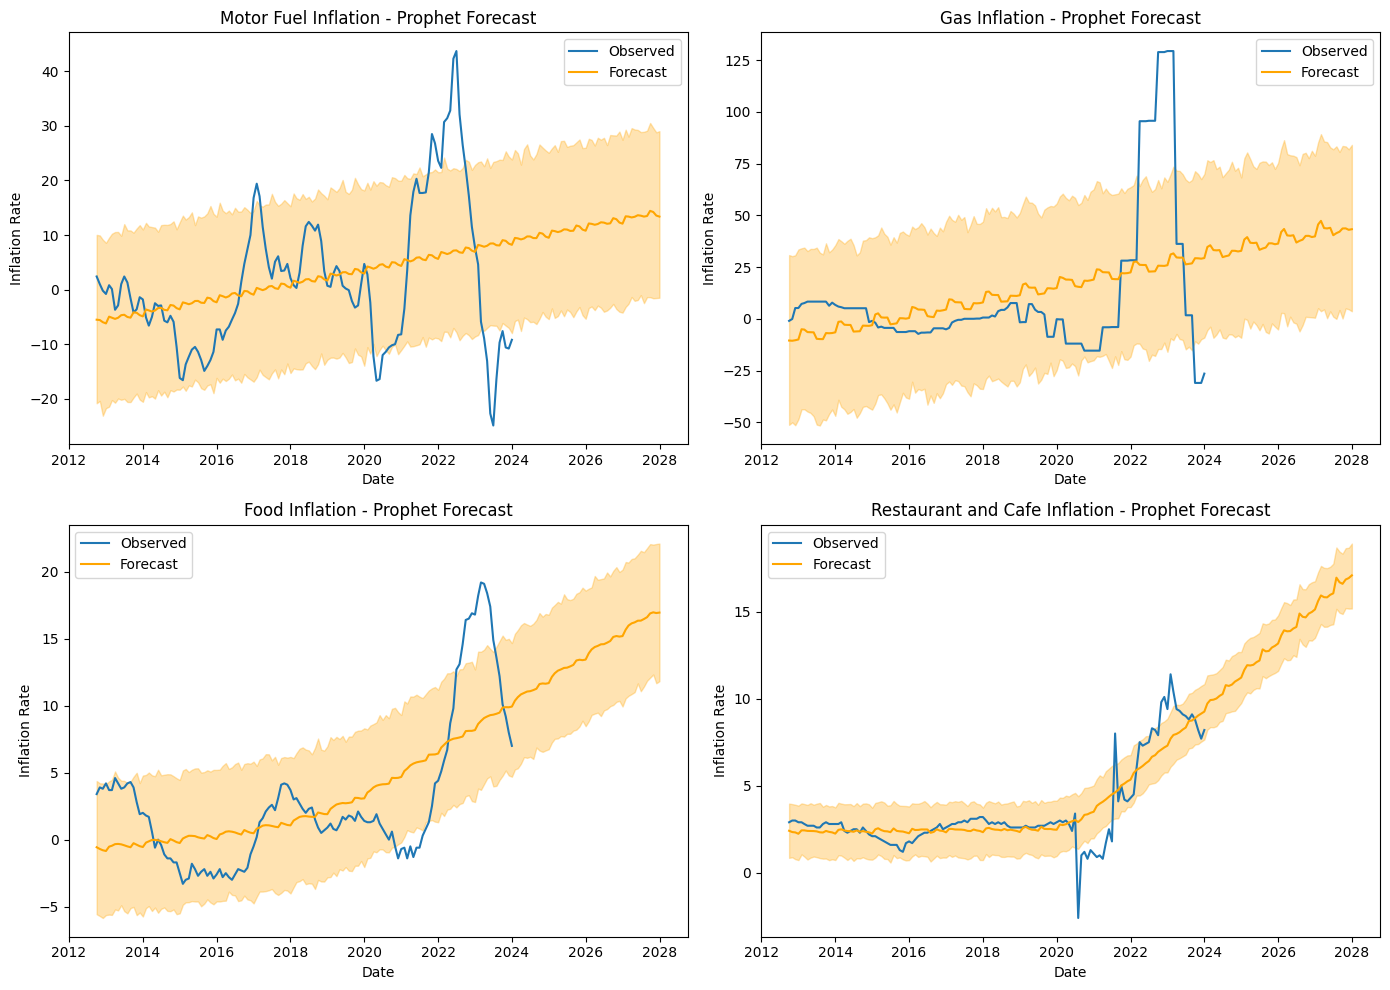

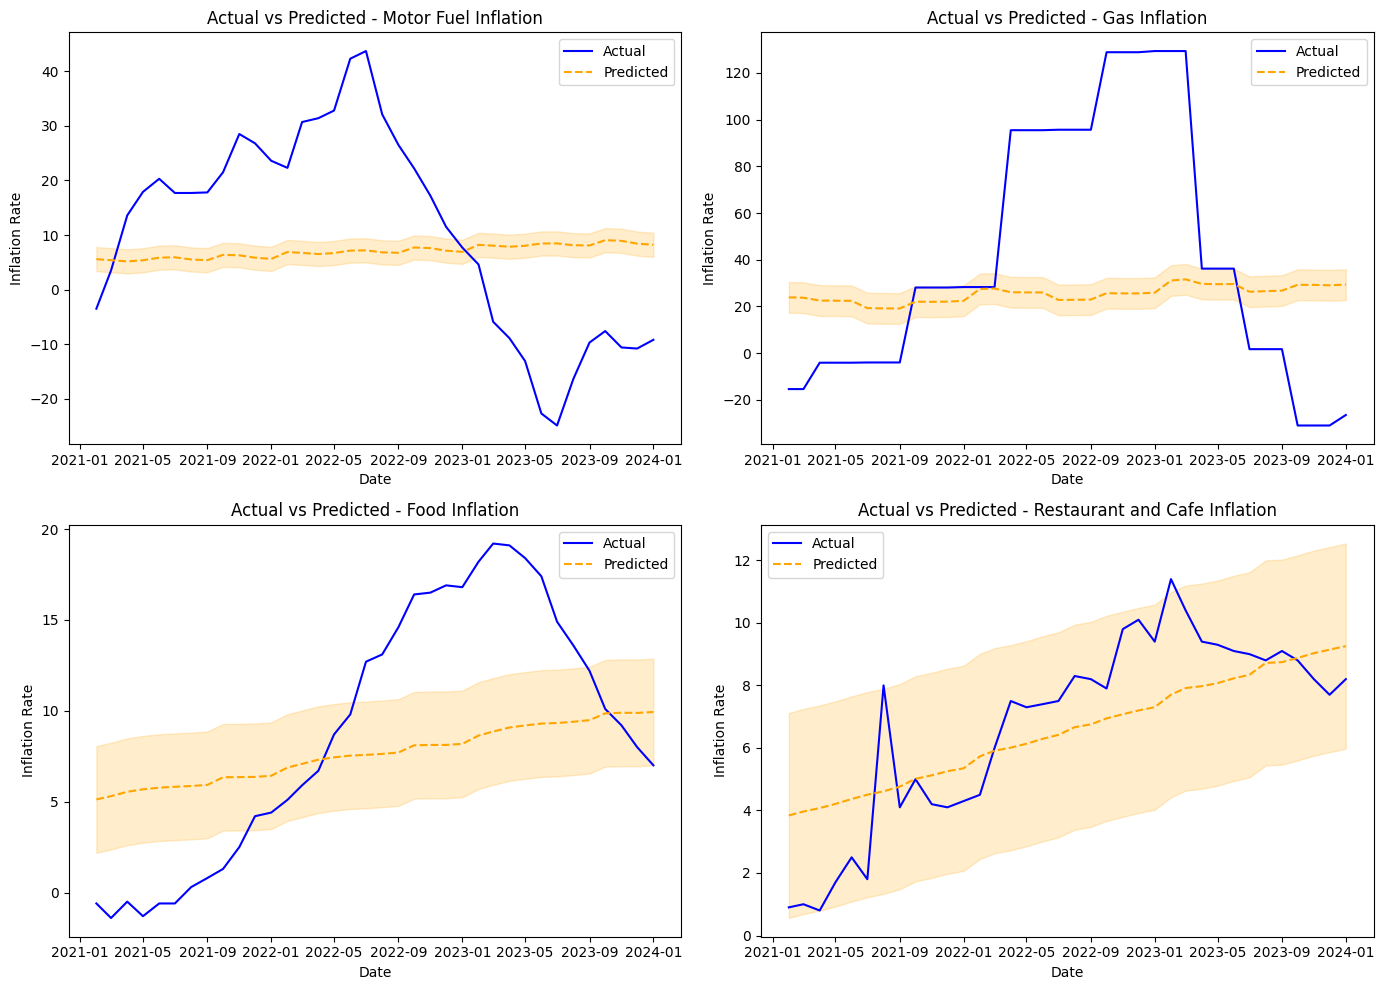

Prophet Model Evaluation Metrics:


Dataset        MAE          MSE       RMSE
0           Motor Fuel Inflation  17.511976   381.930552  19.543044
1                  Gas Inflation  45.009901  3201.721611  56.583757
2                 Food Inflation   5.170771    35.412260   5.950820
3  Restaurant and Cafe Inflation   1.544329     3.403031   1.844731

In [ ]:
# Install Prophet library
!pip install prophet

# Import necessary libraries
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to apply Prophet model
def prophet_forecast(series, title, steps=48):  # üîπ Updated steps to 48 months (4 years)
    # Prepare data for Prophet
    df = series.reset_index()
    df.columns = ['ds', 'y']  # Prophet requires columns 'ds' (date) and 'y' (value)

    # Initialize and fit Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df)

    # Create future dataframe for forecasting
    future = model.make_future_dataframe(periods=steps, freq='M')  # Monthly frequency
    forecast = model.predict(future)

    return forecast, model

# Apply Prophet model to each dataset
motor_fuel_forecast, motor_fuel_model = prophet_forecast(
    Motor_fuel_inflation['Motor fuels'], 'Motor Fuel Inflation', steps=48)

gas_forecast, gas_model = prophet_forecast(
    gas_inflation['Gas'], 'Gas Inflation', steps=48)

food_forecast, food_model = prophet_forecast(
    food_inflation['Food and non-alcoholic beverages'], 'Food Inflation', steps=48)

restaurant_cafe_forecast, restaurant_cafe_model = prophet_forecast(
    restaurant_cafe_inflation['Restaurants and caf√©s'], 'Restaurant and Cafe Inflation', steps=48)

# Dictionary to hold datasets and their Prophet results
datasets = {
    'Motor Fuel Inflation': (Motor_fuel_inflation['Motor fuels'], motor_fuel_forecast, motor_fuel_model),
    'Gas Inflation': (gas_inflation['Gas'], gas_forecast, gas_model),
    'Food Inflation': (food_inflation['Food and non-alcoholic beverages'], food_forecast, food_model),
    'Restaurant and Cafe Inflation': (restaurant_cafe_inflation['Restaurants and caf√©s'], restaurant_cafe_forecast, restaurant_cafe_model)
}

# Plot Prophet forecasts in subplots
plt.figure(figsize=(14, 10))

for i, (title, (series, forecast, _)) in enumerate(datasets.items(), start=1):
    plt.subplot(2, 2, i)
    plt.plot(series.index, series, label='Observed')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
    plt.title(f'{title} - Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.legend()

plt.tight_layout()
plt.show()

# Function to calculate evaluation metrics for test data
def calculate_metrics(series, forecast, steps=36):
    test_data = series[-steps:]
    test_index = test_data.index

    # Align forecast with test data
    forecast_test = forecast.set_index('ds').loc[test_index]

    # Calculate evaluation metrics
    mae = mean_absolute_error(test_data, forecast_test['yhat'])
    mse = mean_squared_error(test_data, forecast_test['yhat'])
    rmse = np.sqrt(mse)

    return mae, mse, rmse, test_data, forecast_test['yhat']

# Store evaluation metrics
metrics_dict = []

# Compare actual vs predicted and calculate metrics
plt.figure(figsize=(14, 10))

for i, (title, (series, forecast, _)) in enumerate(datasets.items(), start=1):
    mae, mse, rmse, test_data, predicted_values = calculate_metrics(series, forecast)

    # Store results
    metrics_dict.append({
        "Dataset": title,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    })

    # Plot actual vs predicted values
    plt.subplot(2, 2, i)
    plt.plot(test_data.index, test_data, label="Actual", color='blue')
    plt.plot(test_data.index, predicted_values, label="Predicted", linestyle="dashed", color="orange")
    plt.fill_between(test_data.index, predicted_values - 1.96 * np.std(predicted_values),
                     predicted_values + 1.96 * np.std(predicted_values), color='orange', alpha=0.2)
    plt.title(f"Actual vs Predicted - {title}")
    plt.xlabel("Date")
    plt.ylabel("Inflation Rate")
    plt.legend()

plt.tight_layout()
plt.show()

# Convert metrics to DataFrame for summary
metrics_df = pd.DataFrame(metrics_dict)

# Display metrics
print("Prophet Model Evaluation Metrics:")
display(metrics_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


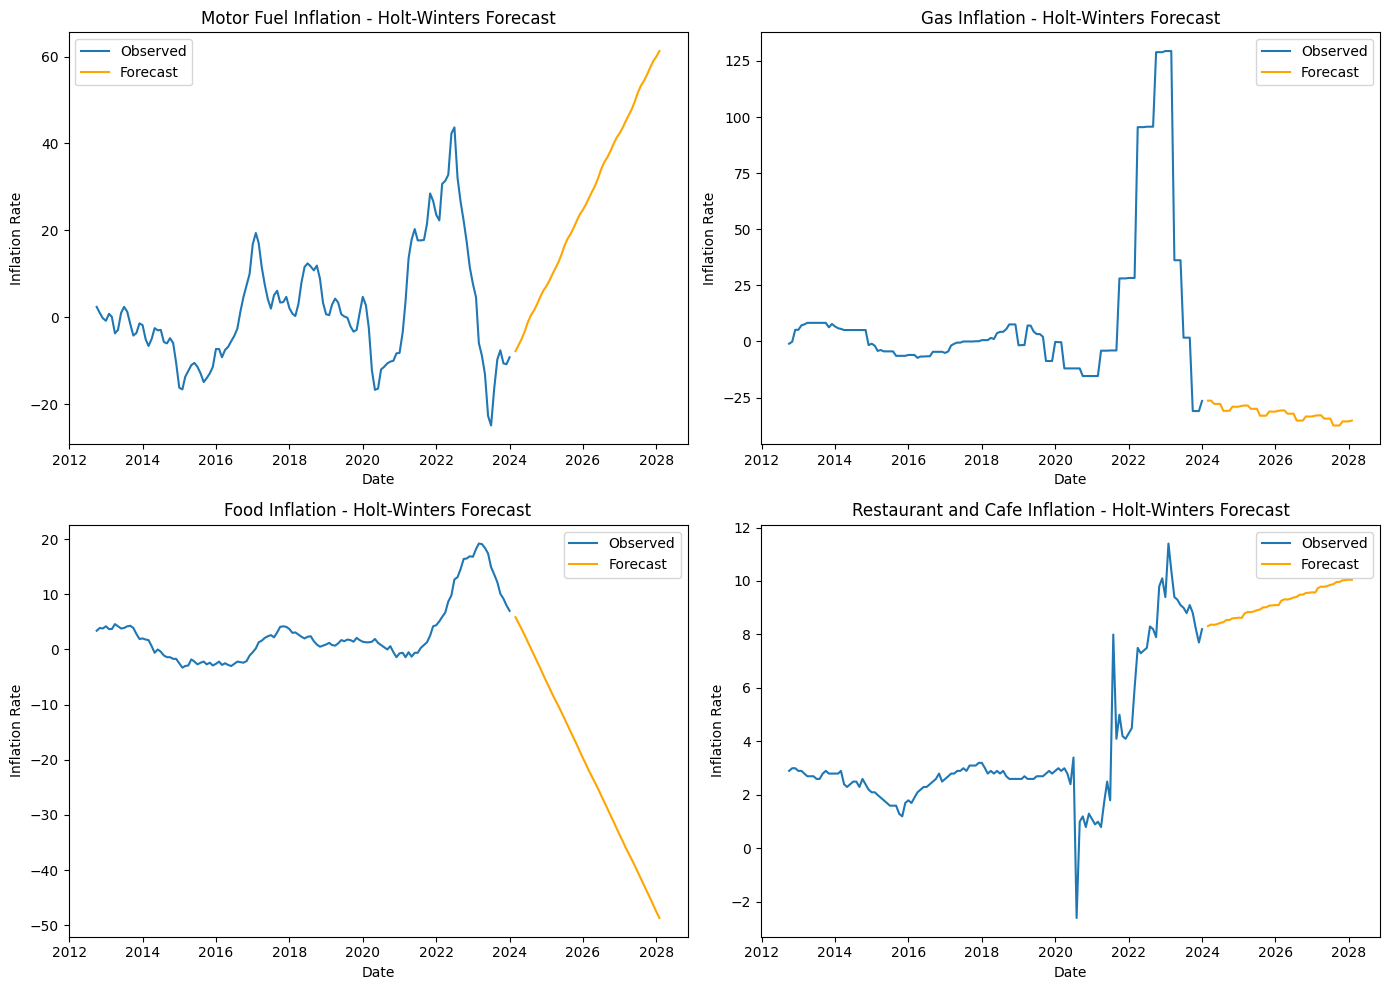

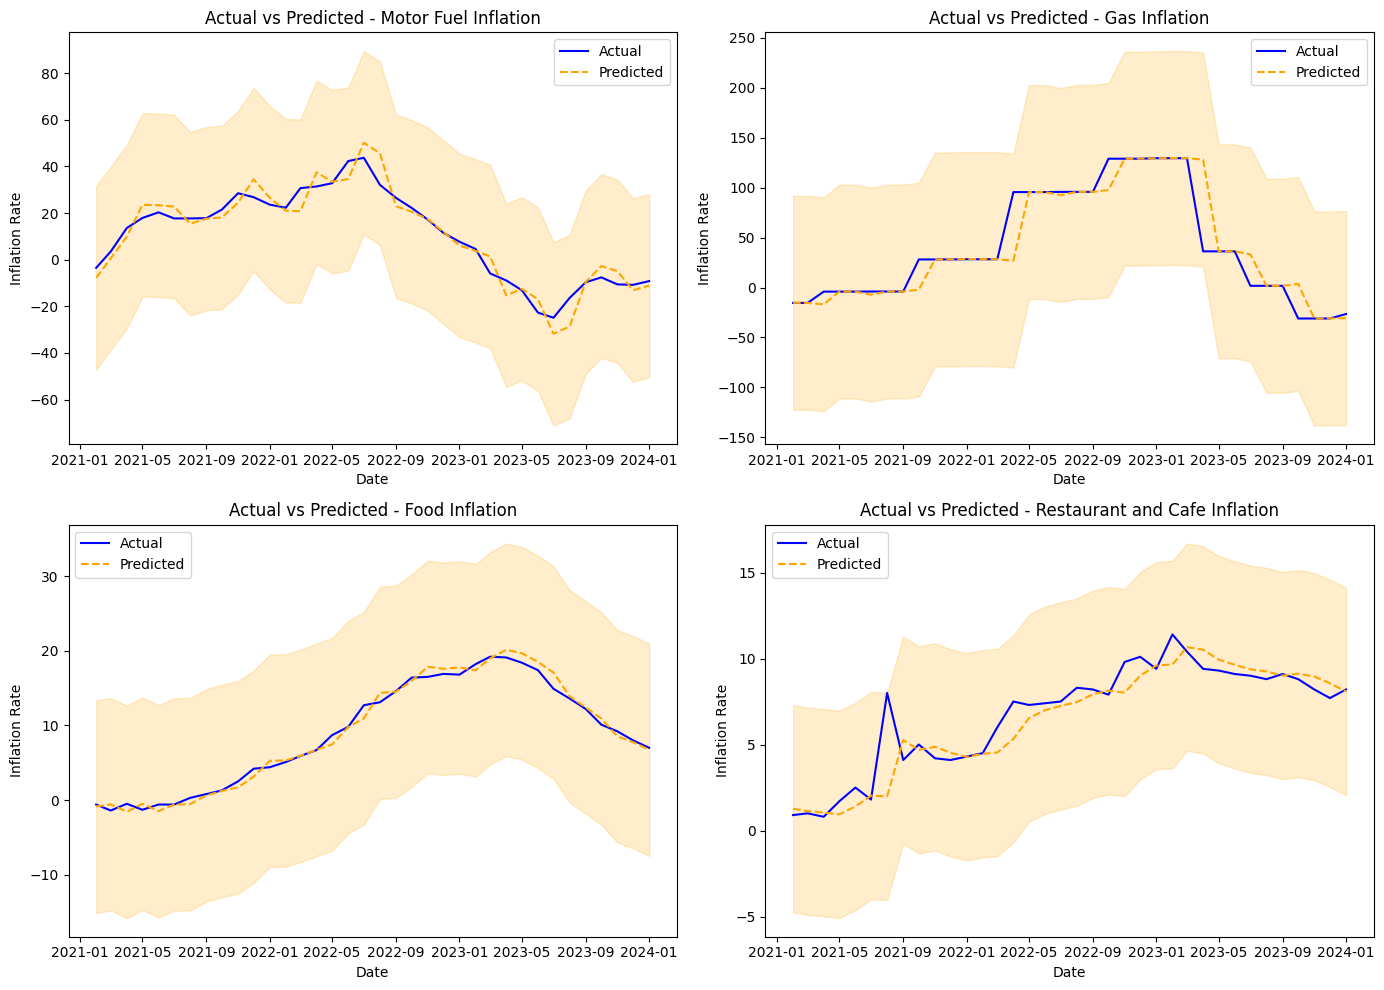

Holt-Winters Model Evaluation Metrics:


Dataset       MAE         MSE       RMSE
0           Motor Fuel Inflation  4.253791   28.853118   5.371510
1                  Gas Inflation  8.697843  483.718399  21.993599
2                 Food Inflation  0.689788    0.751180   0.866706
3  Restaurant and Cafe Inflation  0.782884    1.667968   1.291498

In [ ]:
# Import necessary libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to apply Holt-Winters model
def holt_winters_forecast(series, title, steps=48):  # üîπ Updated steps to 48 months (4 years)
    # Fit Holt-Winters model
    model = ExponentialSmoothing(
        series,
        seasonal_periods=12,  # Monthly data with yearly seasonality
        trend='add',          # Additive trend
        seasonal='add'        # Additive seasonality
    )
    fitted_model = model.fit()

    # Forecast for the specified number of steps
    forecast = fitted_model.forecast(steps=steps)

    return forecast, fitted_model

# Apply Holt-Winters model to each dataset
motor_fuel_forecast, motor_fuel_model = holt_winters_forecast(
    Motor_fuel_inflation['Motor fuels'], 'Motor Fuel Inflation', steps=48)

gas_forecast, gas_model = holt_winters_forecast(
    gas_inflation['Gas'], 'Gas Inflation', steps=48)

food_forecast, food_model = holt_winters_forecast(
    food_inflation['Food and non-alcoholic beverages'], 'Food Inflation', steps=48)

restaurant_cafe_forecast, restaurant_cafe_model = holt_winters_forecast(
    restaurant_cafe_inflation['Restaurants and caf√©s'], 'Restaurant and Cafe Inflation', steps=48)

# Dictionary to hold datasets and their Holt-Winters results
datasets = {
    'Motor Fuel Inflation': (Motor_fuel_inflation['Motor fuels'], motor_fuel_forecast, motor_fuel_model),
    'Gas Inflation': (gas_inflation['Gas'], gas_forecast, gas_model),
    'Food Inflation': (food_inflation['Food and non-alcoholic beverages'], food_forecast, food_model),
    'Restaurant and Cafe Inflation': (restaurant_cafe_inflation['Restaurants and caf√©s'], restaurant_cafe_forecast, restaurant_cafe_model)
}

# Plot Holt-Winters forecasts in subplots
plt.figure(figsize=(14, 10))

for i, (title, (series, forecast, _)) in enumerate(datasets.items(), start=1):
    plt.subplot(2, 2, i)
    plt.plot(series.index, series, label='Observed')
    forecast_index = pd.date_range(series.index[-1], periods=len(forecast) + 1, freq='M')[1:]
    plt.plot(forecast_index, forecast, label='Forecast', color='orange')
    plt.title(f'{title} - Holt-Winters Forecast')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.legend()

plt.tight_layout()
plt.show()

# Function to calculate evaluation metrics for test data
def calculate_metrics(series, model, steps=36):
    test_data = series[-steps:]
    test_index = test_data.index

    # Get predictions for test period
    predictions = model.predict(start=test_index[0], end=test_index[-1])
    predicted_values = predictions[-steps:]  # Align with test data

    # Calculate evaluation metrics
    mae = mean_absolute_error(test_data, predicted_values)
    mse = mean_squared_error(test_data, predicted_values)
    rmse = np.sqrt(mse)

    return mae, mse, rmse, test_data, predicted_values

# Store evaluation metrics
metrics_dict = []

# Compare actual vs predicted and calculate metrics
plt.figure(figsize=(14, 10))

for i, (title, (series, _, model)) in enumerate(datasets.items(), start=1):
    mae, mse, rmse, test_data, predicted_values = calculate_metrics(series, model)

    # Store results
    metrics_dict.append({
        "Dataset": title,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse
    })

    # Plot actual vs predicted values
    plt.subplot(2, 2, i)
    plt.plot(test_data.index, test_data, label="Actual", color='blue')
    plt.plot(test_data.index, predicted_values, label="Predicted", linestyle="dashed", color="orange")
    plt.fill_between(test_data.index, predicted_values - 1.96 * np.std(predicted_values),
                     predicted_values + 1.96 * np.std(predicted_values), color='orange', alpha=0.2)
    plt.title(f"Actual vs Predicted - {title}")
    plt.xlabel("Date")
    plt.ylabel("Inflation Rate")
    plt.legend()

plt.tight_layout()
plt.show()

# Convert metrics to DataFrame for summary
metrics_df = pd.DataFrame(metrics_dict)

# Display metrics
print("Holt-Winters Model Evaluation Metrics:")
display(metrics_df)